In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import re, pip, conda
import time
import os

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv(r"D:\myJupyter\机器学习\datasets\House Price\train_encode.csv",index_col=0)
#回归数据
X = data.iloc[:,:-1]
y = data.iloc[:,-1]#导入2个最简单的分类数据集：乳腺癌数据集与手写数字数据集
from sklearn.datasets import load_breast_cancer, load_digits

#二分类数据
X_binary = load_breast_cancer().data
y_binary = load_breast_cancer().target
data_binary = xgb.DMatrix(X_binary,y_binary)

#多分类数据
X_multi = load_digits().data
y_multi = load_digits().target
data_multi = xgb.DMatrix(X_multi, y_multi)



# 二 XGBoost的参数

在之前的课程当中，我们已经认识了几个xgboost的参数，包括设置迭代次数的`num_boost_round`，设置损失函数的`objective`，设置评估指标的`eval_matric`，以及设置多分类类别数的`num_class`。这些参数有些是在params中设置的参数，有些是需要在方法`.train`或者`.cv`中设置的参数，但这些参数只是xgboost参数的九牛一毛。由于xgboost本身是一个复杂的算法系统，其超参数的数量十分惊人，我已经将可能用到的参数总结在了如下表格当中，其中标注为绿色的是我们未曾学过、或必须讲解的重要参数。

|类型|参数|
|-|-|
|**迭代过程/目标函数**|**params**: eta, base_score, objective, <font color="green">**lambda, gamma, alpha, max_delta_step**</font><br>**xgb.train()**: num_boost_round|
|**弱评估器结构**|**params**: max_depth, <font color="green">**booster, min_child_weight**</font>|
|**dart树**|**params**: <font color="green">**sample_type, normalized_type, rate_drop, one_drop, skip_drop**</font>|
|**弱评估器的训练数据**|**params**: subsample, <font color="green">**sampling_method, colsamle_bytree, colsample_bylevel, colsample_bynode**</font>|
|**提前停止**|**xgb.train()**: <font color="green">**early_stopping_rounds, evals**</font>, eval_metric|
|**其他**|**params**: seed, <font color="green">**verbosity, scale_pos_weight, nthread**</font>|

需要的时，在实现xgboost的两种方式中（原生代码与sklearn API），参数的名称可能不同。**在后续课程当中，我将会持续使用原生代码进行讲解，并附上该参数在sklearn API下的名称**。有的参数可能只能在原生代码中使用，如果出现该情况，则会特殊标注出来。在后续案例课程当中，我们将会大量使用xgboost的原生代码，强烈建议以xgboost原生代码为核心进行学习，如果你考虑继续使用sklearn API，可以参考之前课程中所有适用于sklearn的代码，大部分代码都适用。

## 1 迭代过程

### 1.1 迭代次数/学习率/初始$H_0$/最大迭代值

作为Boosting算法，XGBoost的迭代流程与GBDT高度相似，因此XGBoost自然而然也有设置具体迭代次数的参数`num_boost_round`、学习率参数`eta`以及设置初始迭代值的`base_score`。

具体地来说，对于样本$x_i$，集成算法当中一共有$K$棵树，则参数`num_boost_round`的取值为K。假设现在正在建立第$k$个弱评估器，则第$k$个弱评估器上$x_i$的结果可以表示为$f_k(x_i)$。假设整个Boosting算法对样本$x_i$输出的结果为$H(x_i)$，则该结果一般可以被表示为k=1~k=K过程当中，所有弱评估器结果的加权求和：

$$H(x_i) =  \sum_{k=1}^{\color{red}K}
\phi_kf_k(x_i)
$$

其中，$\phi_k$为第k棵树的权重。特别的，XGBoost算法不计算树权重，因此XGBoost的输出结果为：

$$H(x_i) =  \sum_{k=1}^{\color{red}K}f_k(x_i)
$$

对于第$k$次迭代来说，则有：

$$H_k(x_i) = H_{k-1}(x_i) + f_k(x_i)
$$

在这个一般过程中，每次将本轮建好的决策树加入之前的建树结果时，可以增加参数$\color{red}\eta$，表示为第k棵树加入整体集成算法时的学习率，对标参数`eta`。

$$H_k(x_i) = H_{k-1}(x_i) + \boldsymbol{\color{red}\eta} f_k(x_i)
$$

该学习率参数控制Boosting集成过程中$H(x_i)$的增长速度，是相当关键的参数。当学习率很大时，$H(x_i)$增长得更快，我们所需的`num_boost_round`更少，当学习率较小时，$H(x_i)$增长较慢，我们所需的`num_boost_round`就更多，因此boosting算法往往会需要在`num_boost_round`与`eta`中做出权衡。在XGBoost当中，`num_boost_round`的默认值为10，`eta`的默认值为0.3，如果你熟悉GBDT算法，那你也一定熟悉这两个参数，故此不再赘述。

- 参数`base_score`

在上述过程中，我们建立第一个弱评估器时有：

$$H_1(x_i) = H_{0}(x_i) + \eta f_1(x_i)
$$

由于没有第0棵树的存在，因此$H_0(x_i)$的值在数学过程及算法具体实现过程中都需要进行单独的确定，而这个值就由`base_score`确定。在xgboost中，我们可以对`base_score`输出**任何数值**，但并不支持类似于GBDT当中输入评估器的操作。当不填写时，该参数的默认值为0.5，即对所有样本都设置0.5为起始值。当迭代次数足够多、数据量足够大时，调整算法的$H_0(x_i)$意义不大，因此我们基本不会调整这个参数。

- 参数`max_delta_step`

在迭代过程当中，XGBoost有一个独特的参数`max_delta_step`。这个参数代表了每次迭代时被允许的最大$\eta f_k(x_i)$。当参数`max_delta_step`被设置为0，则说明不对每次迭代的$\eta f_k(x_i)$大小做限制，如果该参数被设置为正数C，则代表$\eta f_k(x_i) \leq C$，否则就让算法执行：

$$H_k(x_i) = H_{k-1}(x_i) + C
$$

通常来说这个参数是不需要的，但有时候这个参数会对极度不均衡的数据有效。如果样本极度不均衡，那可以尝试在这个参数中设置1~10左右的数。

总结：

|参数含义|原生代码|sklearn API|
|:-:|:-:|:-:|
|迭代次数/树的数量|**num_boost_round**<br>(xgb.train)|**n_estimators**|
|学习率|**eta**<br>(params)|**learning_rate**|
|初始迭代值|**base_score**<br>(params)|**base_score**|
|一次迭代中所允许的最大迭代值|**max_delta_step**<br>(params)|**max_delta_step**|

注意，在XGBoost原生论文当中使用$\Phi(x)$作为树输出结果的表示，并且让$f(x) = \eta \Phi(x)$，并且全程避免了使用字母$H$，因为在xgboost的体系当中，字母$H$代表着相当重要的另一个存在。在我们的课程中，为与之前的课程保持一致，我们还是使用$H(x)$来表示最终模型的输出结果，$f(x)$作为树输出结果的表示，并将学习率$\eta$单独呈现，但在阅读XGBoost原论文时，注意避免混淆。

### 1.2 xgboost的目标函数

在之前的课程当中，我们已经简单介绍过xgboost常用的几种损失函数。与GBDT一样，xgboost的损失函数理论上可以推广到任意可微函数，因此只要是我们在之前的课程中介绍过的损失函数都可以被用于xgboost。但与GBDT不同的是，xgboost并不向着损失函数最小化的方向运行，而是如我们在前面所提到的，**xgboost向着令目标函数最小化的方向运行**。

需要注意的是，损失函数可以针对单个样本进行计算，也可以针对整个算法进行计算，**但在XGBoost的定义中，目标函数是针对每一棵树的，而不是针对一个样本或整个算法**。对任意树$f_k$来说，目标函数有两个组成部分，一部分是任意可微的损失函数，它控制模型的**经验风险**。从数值上来说，它等于现在树上所有样本上损失函数之和，其中单一样本的损失为$l(y_i,\hat{y_i})$。另一部分是控制模型复杂度的$\Omega(f_k)$，它控制当前树的**结构风险**。<br>

$$Obj_k = \sum_{i=1}^Ml(y_i,\hat{y_i}) + \Omega(f_k)
$$<br>

其中$M$表示现在这棵树上一共使用了M个样本，$l$表示单一样本的损失函数。当模型迭代完毕之后，最后一棵树上的目标函数就是整个XGBoost算法的目标函数。

- **经验风险**：模型对数据学习越深入，损失越小（经验风险越小），模型对数据学习得越浅显，损失越大（经验风险越大）。

- **结构风险**：树结构越复杂、模型复杂度越高，过拟合风险越大（结构风险越大）。树模型结构越简单、模型复杂度越低、过拟合风险越小（结构风险越小）。

通常来说，模型需要达到一定的复杂度，才能保证较小的损失，但如果只追求最小的经验风险，反而容易导致过拟合。相对的，如果只追求模型复杂度低、结构风险低，那模型又容易陷入欠拟合的困局、损失函数过高，因此平衡结构风险与经验风险十分关键。XGBoost向着目标函数最小化的方向运行，可以保证在迭代过程中，经验风险和结构风险都不会变得太大，因此模型的损失不会太大、同时又不会太容易过拟合。这一目标函数的设计可谓相当聪明。

在具体的公式当中，结构风险$\Omega(f_k)$又由两部分组成，一部分是控制树结构的$\gamma T$，另一部分则是正则项：


$$\Omega(f_k) = \boldsymbol{\color{red}\gamma} T + \frac{1}{2}\boldsymbol{\color{red}\lambda}\sum_{j=1}^Tw_j^2 + \boldsymbol{\color{red}\alpha}\sum_{j=1}^Tw_j
$$


其中$\gamma$，$\lambda$与$\alpha$都是可以自由设置的系数，而$T$表示当前第$k$棵树上的叶子总量，$w_j$则代表当前树上第$j$片叶子的叶子权重（leaf weights）。**叶子权重是XGBoost数学体系中非常关键的一个因子，它实际上就是当前叶子$j$的预测值**，这一指标与数据的标签量纲有较大的关系，因此当标签的绝对值较大、$w_j$值也会倾向于越大。因此正则项有两个：使用平方的L2正则项与使用绝对值的L1正则项，因此完整的目标函数表达式为：

$$Obj_k = \sum_{i=1}^Ml(y_i,\hat{y_i}) + \boldsymbol{\color{red}\gamma} T + \frac{1}{2}\boldsymbol{\color{red}\lambda}\sum_{j=1}^Tw_j^2 + \boldsymbol{\color{red}\alpha}\sum_{j=1}^Tw_j$$

不难发现，所有可以自由设置的系数都与结构风险有关，这三个系数也正对应着xgboost中的三个参数：`gamma`，`alpha`与`lambda`。

- 参数`gamma`：乘在一棵树的叶子总量$T$之前，依照叶子总量对目标函数施加惩罚的系数，默认值为0，可填写任何[0, ∞]之间的数字。当叶子总量固定时，`gamma`越大，结构风险项越大；同时，当`gamma`不变时，叶子总量越多、模型复杂度越大，结构风险项也会越大。在以上两种情况下，目标函数受到的惩罚都会越大，因此**调大`gamma`可以控制过拟合**。<br><br>
- 参数`alpha`与`lambda`：乘在正则项之前，依照叶子权重的大小对目标函数施加惩罚的系数，也就是正则项系数。`lambda`的默认值为1，`alpha`的默认值为0，因此xgboost默认使用L2正则化。通常来说，我们不会同时使用两个正则化，但我们也可以尝试这么做。$\sum_{j=1}^Tw_j$是当前树上所有叶子的输出值之和，因此当树上的叶子越多、模型复杂度越大时，$\sum_{j=1}^Tw_j$自然的数值自然会更大，因此当正则项系数固定时，模型复杂度越高，对整体目标函数的惩罚就越重。当$w$固定时，正则项系数越大，整体目标函数越大，因此**调大`alpha`或`lambda`可以控制过拟合**。

|参数含义|原生代码|sklearn API|
|:-:|:-:|:-:|
|乘在叶子节点数量前的系数|**gamma**<br>(params)|**gamma**|
|L2正则项系数|**lambda**<br>(params)|**reg_lambda**|
|L1正则项系数|**alpha**<br>(params)|**reg_alpha**|

然而，在实际控制过拟合的过程中，大家可能经常会发现这几个参数“无效”。比如我们可以看到：

In [ ]:
import xgboost as xgb

data_xgb = xgb.DMatrix(X,y)
params_default = {"max_depth":5,"seed":1412}
result_default = xgb.cv(params_default,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
result_default.iloc[-1,:]

train-rmse-mean     2362.659668
train-rmse-std       218.221383
test-rmse-mean     28623.220313
test-rmse-std       7526.333222
Name: 99, dtype: float64

In [ ]:
#定义一个函数，用来检测模型迭代完毕后的过拟合情况
def overfitcheck(result):
    return (result.iloc[-1,2] - result.iloc[-1,0]).min()

In [ ]:
overfitcheck(result_default)

26260.560644800004

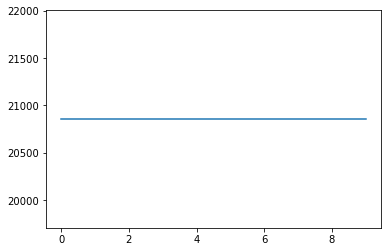

In [ ]:
train = []
test = []
gamma = np.arange(0,10,1)
overfit = []
for i in gamma:
    params = {"max_depth":5,"seed":1412,"eta":0.1
              ,"gamma":float(i)
             }
    result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])
plt.plot(gamma,overfit);

绘制gamma与train的图像再观察：

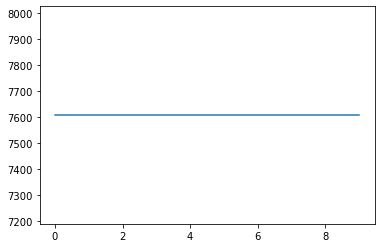

In [ ]:
plt.plot(gamma,train);

如上所示，训练集结果纹丝不动，过拟合程度也纹丝不动。这是不是`gamma`失效了呢？实际上，**对于没有上限或下限的参数，我们要关注参数的敏感度。**如果参数值稍稍移动，模型就变化很大，那参数敏感，如果参数值移动很多，模型才能有变化，那参数不敏感。当树的结构相对复杂时，`gamma`会比敏感，否则`gamma`可能非常迟钝。当原始标签数值很大、且叶子数量不多时，`lambda`和`alpha`就会敏感，如果原始标签数值很小，这两个参数就不敏感。因此在使用这些参数之前，最好先对参数的敏感程度有一个探索，这里很容易看到：

- 当前树结构不复杂，`gamma`不敏感

In [ ]:
train = []
test = []
gamma = np.arange(0,10000000,1000000)
overfit = []
for i in gamma:
    params = {"max_depth":5,"seed":1412,"eta":0.1
              ,"gamma":float(i)
              #,"lambda":400
             }
    result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])

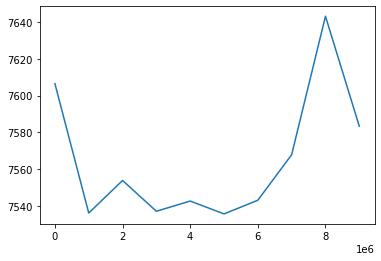

In [ ]:
plt.plot(gamma,train);

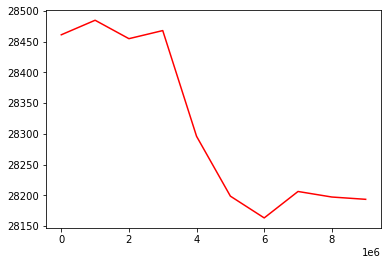

In [ ]:
plt.plot(gamma,test,color="red");

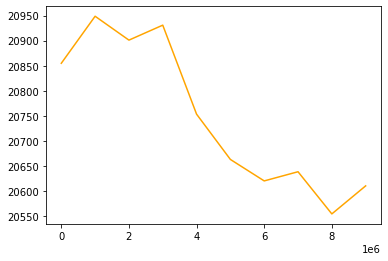

In [ ]:
plt.plot(gamma,overfit,color="orange");

`gamma`控制过拟合的最好成绩：

In [ ]:
min(overfit)

20554.4015628

- 当前标签值较大，因此预测标签的值也较大，`lambda`会更敏感

In [ ]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
train = []
test = []
lambda_ = np.arange(1,2,0.1)
overfit = []
for i in lambda_:
    params = {"max_depth":5,"seed":1412,"eta":0.1
              ,"lambda":float(i)
             }
    result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])

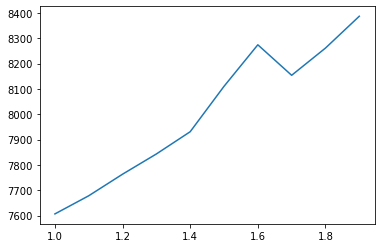

In [ ]:
plt.plot(lambda_,train);

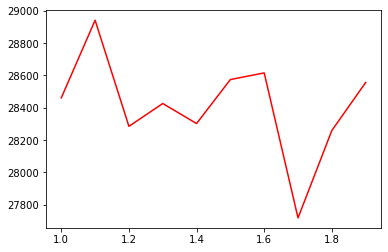

In [ ]:
plt.plot(lambda_,test,color="red");

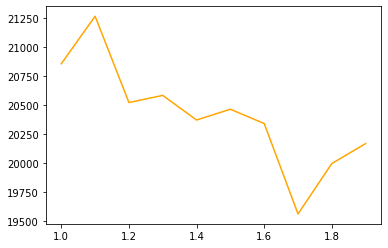

In [ ]:
plt.plot(lambda_,overfit,color="orange");

`lambda`控制过拟合的最好成绩：

In [ ]:
min(overfit)

19564.888281400003

可见，现在`lambda`比`gamma`有效。当然，在实际使用时，并不是在所有数据情况下都如此，需要根据具体情况具体分析。因此在使用和调节这些参数时，要先考虑适合的参数范围，否则再多的搜索也是无用。总结一下，在整个迭代过程中，我们涉及到了如下参数：

|类型|参数|
|---|---|
|**迭代过程/损失函数**|num_boost_round：集成算法中弱分类器数量，对Boosting算法而言为实际迭代次数<br><br>eta：Boosting算法中的学习率，影响弱分类器结果的加权求和过程<br><br><font color="green">**objective**</font>：选择需要优化的损失函数<br><br><font color="green">**base_score**</font>：初始化预测结果$H_0$的设置<br><br><font color="green">**max_delta_step**</font>：一次迭代中所允许的最大迭代值<br><br><font color="green">**gamma**</font>：乘在叶子数量前的系数，放大可控制过拟合<br><br><font color="green">**lambda**</font>：L2正则项系数，放大可控制过拟合<br><br><font color="green">**alpha**</font>：L1正则项系数，放大可控制过拟合|

## 2 XGBoost的弱评估器

### 2.1 三大评估器与DART树

梯度提升算法当中不只有梯度提升树，也可集成其他模型作为弱评估器，而作为梯度提升树进化版的XGBoost算法，自然也不是只有CART树一种弱评估器。在XGBoost当中，我们还可以选型线性模型，比如线性回归或逻辑回归来集成，同时还可以选择与CART树有区别的另一种树：DART树。在XGBoost当中，我们使用参数`booster`来控制我们所使用的具体弱评估器。

- 参数`booster`：使用哪种弱评估器。
> 可以输入"gbtree"、"gblinear"或者"dart"。<br><br>
> 输入"gbtree"表示使用遵循XGBoost规则的CART树，我们之前提到的XGBoost在GBDT上做出的改善基本都是针对这一类型的树。这一类型的树又被称为“XGBoost独有树”，XGBoost Unique Tree。<br><br>
> 输入"dart"表示使用抛弃提升树，DART是Dropout Multiple Additive Regression Tree的简称。这种建树方式受深度学习中的Dropout技巧启发，在建树过程中会随机抛弃一些树的结果，可以更好地防止过拟合。在数据量巨大、过拟合容易产生时，DART树经常被使用，但由于会随机地抛弃到部分树，可能会伤害模型的学习能力，同时可能会需要更长的迭代时间。<br><br>
> 输入"gblinear"则表示使用线性模型，当弱评估器类型是"gblinear"而损失函数是MSE时，表示使用xgboost方法来集成线性回归。当弱评估器类型是"gblinear"而损失函数是交叉熵损失时，则代表使用xgboost来集成逻辑回归。<br><br>
> 每一种弱评估器都有自己的params列表，例如只有树模型才会有学习率等参数，只有DART树才会有抛弃率等参数。评估器必须与params中的参数相匹配，否则一定会报错。其中，由于DART树是从gbtree的基础上衍生而来，因此gbtree的所有参数DART树都可以使用。

|参数含义|原生代码|sklearn API|
|:-:|:-:|:-:|
|选择使用不同的弱评估器|**booster**<br>(params)|**booster**|

在上述三种树当中，DART树的参数需要单独进行说明。DART树的建树过程与普通提升树gbtree完全一致，但在集成树结果的过程中与传统gbtree有所区别。具体地来说，提升树的模型输出结果往往等于所有树结果的加权求和：

$$H(x_i) =  \sum_{k=1} ^ {\color{red}K} f_k(x_i)
$$

在第$k$次迭代中建立新的树时，迭代后的结果等于之前所有${k-1}$棵树的结果加新建立的树的结果:

$$H_k(x_i) = H_{k-1}(x_i) + \boldsymbol{\color{red}\eta} f_k(x_i)
$$

DART树在**每一次迭代**前都会随机地抛弃部份树，即不让这些树参与$H_{k-1}(x_i)$的计算，这种随机放弃的方式被叫做“Dropout”（抛弃）。举例说明，假设现在一共有5棵树，结果分别如下：

||k=1|k=2|k=3|k=4|k=5|
|:-:|:-:|:-:|:-:|:-:|:-:|
|$\eta f_k(x_i)$|1|0.8|0.6|0.5|0.3|

当建立第6棵树时，普通提升树的$H_{k-1}(x_i)$ = 1+0.8+0.6+0.5+0.3 = 3.2。对于DART树来说，我们可以认为设置抛弃率`rate_drop`，假设抛弃率为0.2，则DART树会随机从5棵树中抽样一棵树进行抛弃。假设抛弃了第二棵树，则DART树的$H_{k-1}(x_i)$ = 1+0.6+0.5+0.3 = 2.4。通过影响$H_{k-1}(x_i)$，DART树影响损失函数、影响整个算法的输出结果$H(x)$，以此就可以在每一次迭代中极大程度地影响整个xgboost的方向。

在一般的抗过拟合方法当中，我们只能从单棵树的学习能力角度入手花式对树进行剪枝，但DART树的方法是对整体迭代过程进行控制。在任意以“迭代”为核心的算法当中，我们都面临同样的问题，即**最开始的迭代极大程度地影响整个算法的走向，而后续的迭代只能在前面的基础上小修小补**。这一点从直觉上来说很好理解，毕竟当我们在绘制损失函数的曲线时，会发现在刚开始迭代时，损失函数急剧下降，但随后就逐渐趋于平缓。在这个过程中，没有任何过拟合手段可以从流程上影响到那些先建立的、具有巨大影响力的树，但DART树就可以削弱这些前端树的影响力，大幅提升抗过拟合的能力。

在这个过程中，我们涉及到以下的几个参数：

- 参数`rate_drop`：每一轮迭代时抛弃树的比例
> 设置为0.3，则表示有30%的树会被抛弃。只有当参数`booster`="dart"时能够使用，只能填写[0.0,1.0]之间的浮点数，默认值为0。
- 参数`one_drop`：每一轮迭代时至少有`one_drop`棵树会被抛弃
> 可以设置为任意正整数，例如`one_drop` = 10，则意味着每轮迭代中至少有10棵树会被抛弃。<br><br>
> 当参数`one_drop`的值高于`rate_drop`中计算的结果时，则按照`one_drop`中的设置执行Dropout。例如，总共有30棵树，`rate_drop`设置为0.3，则需要抛弃9棵树。但`one_drop`中设置为10，则一定会抛弃10棵树。当`one_drop`的值低于`rate_drop`的计算结果时，则按`rate_drop`的计算结果执行Dropout。
- 参数`skip_drop`：每一轮迭代时可以不执行dropout的概率
> 即便参数`booster`='dart'，每轮迭代也有`skip_drop`的概率可以不执行Dropout，是所有设置的概率值中拥有最高权限的参数。该参数只能填写[0.0,1.0]之间的浮点数，默认值为0。当该参数为0时，则表示每一轮迭代都一定会抛弃树。如果该参数不为0，则有可能不执行Dropout，直接按照普通提升树的规则建立新的提升树。<br><br>
> 需要注意的是，`skip_drop`的权限高于`one_drop`。即便`one_drop`中有所设置，例如每次迭代必须抛弃至少10棵树，但只要`skip_drop`不为0，每轮迭代则必须经过`skip_drop`的概率筛选。如果`skip_drop`说本次迭代不执行Dropout，则忽略`one_drop`中的设置。
- 参数`sample_type`：抛弃时所使用的抽样方法
> 填写字符串"uniform"：表示均匀不放回抽样。<br><br>
> 填写字符串"weighted"：表示按照每棵树的权重进行有权重的不放回抽样。<br><br>
> 注意，该不放回是指在一次迭代中不放回。**每一次迭代中的抛弃是相互独立的，因此每一次抛弃都是从所有树中进行抛弃**。上一轮迭代中被抛弃的树在下一轮迭代中可能被包括。
- 参数`normalize_type`：增加新树时，赋予新树的权重
> 当随机抛弃已经建好的树时，可能会让模型结果大幅度偏移，因此往往需要给与后续的树更大的权重，让新增的、后续的树在整体算法中变得更加重要。所以DART树在建立新树时，会有意地给与后续的树更大的权重。我们有两种选择：<br><br>
> 填写字符串"tree"，表示新生成的树的权重等于所有被抛弃的树的权重的均值。<br><br>
> 填写字符串"forest"，表示新生成的树的权重等于所有被抛弃的树的权重之和。
> 算法默认为"tree"，当我们的dropout比例较大，且我们相信希望给与后续树更大的权重时，会选择"forest"模式。

你是否注意到，我们的两个参数`sample_type`与`normalize_type`都使用了概念“树的权重”，但我们在之前讲解XGBoost的基本流程时提到过，XGBoost并不会针对每一棵树计算特定的权重。这个**树的权重其实指的是整棵树上所有叶子权重之和**。那究竟是怎样让新增加的树的权重刚好就等于原本被抛弃的树的权重的均值或和呢？这就需要一个相对复杂的数学过程来进行解答了，如果你感兴趣，可以查看这一篇说明：https://xgboost.readthedocs.io/en/stable/tutorials/dart.html

当我们在应用的时候，这个点并不会对我们造成影响，只要知道参数如何使用即可。**同时，所有dart树相关的参数在原生代码与sklearn代码中都完全一致**。

当模型容易过拟合时，我们可以尝试让模型使用DART树来减轻过拟合。不过DART树也会带来相应的问题，最明显的缺点就是：

- 用于微调模型的一些树可能被抛弃，微调可能失效
- 由于存在随机性，模型可能变得不稳定，因此提前停止等功能可能也会变得不稳定
- 由于要随机抛弃一些树的结果，在工程上来说就无法使用每一轮之前计算出的$H_{k-1}$，而必须重新对选中的树结果进行加权求和，可能导致模型迭代变得略微缓慢

In [ ]:
data_xgb = xgb.DMatrix(X,y)
params_dart = {"max_depth":5 ,"seed":1412, "eta":0.1
                  ,"booster":"dart","sample_type": "uniform"
                  ,"normalize_type":"tree"
                  ,"rate_drop": 0.2
                  ,"skip_drop": 0.5}
result_dart = xgb.cv(params_dart,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )

In [ ]:
result_dart.iloc[-1,:]

train-rmse-mean     9906.142188
train-rmse-std       317.321406
test-rmse-mean     28262.178906
test-rmse-std       8082.918652
Name: 99, dtype: float64

In [ ]:
overfitcheck(result_dart)

18356.036718800002

可以看出，dart树抗过拟合效果比`gamma`、`lambda`等参数更强，不过在提升模型的测试集表现上，dart树还是略逊一筹，毕竟dart树会伤害模型的学习能力。

### 2.2 弱评估器的分枝

当参数`booster`的值被设置为gbtree时，XGBoost所使用的弱评估器是改进后的的CART树，其分枝过程与普通CART树高度一致：向着叶子质量提升/不纯度下降的方向分枝、并且每一层都是二叉树。在CART树的基础上，XGBoost创新了全新的分枝指标：**结构分数（Structure Score）与结构分数增益（Gain of Structure Score）**（也被叫做结构分数之差），更大程度地保证了CART树向减小目标函数的方向增长。需要注意的是，**XGBoost不接受其他指标作为分枝指标**，因此你会发现在众多的xgboost的参数中，并不存在`criterion`参数：

|类型|参数|
|-|-|
|**迭代过程/目标函数**|**params**: eta, base_score, objective, <font color="green">**lambda, gamma, alpha, max_delta_step**</font><br>**xgb.train()**: num_boost_round|
|**弱评估器结构**|**params**: max_depth, <font color="green">**booster, min_child_weight**</font>|
|**dart树**|**params**: <font color="green">**sample_type, normalized_type, rate_drop, one_drop, skip_drop**</font>|
|**弱评估器的训练数据**|**params**: subsample, <font color="green">**sampling_method, colsamle_bytree, colsample_bylevel, colsample_bynode**</font>|
|**提前停止**|**xgb.train()**: <font color="green">**early_stopping_rounds, evals**</font>, eval_metric|
|**其他**|**params**: seed, <font color="green">**verbosity, scale_pos_weight, nthread**</font>|

<br>幸运的是，没有任何参数与结构分数的公式本身相关，因此从应用xgboost的角度来看，我们并不需要对结构分数以及相应的分枝过程理解太深，只需对公式稍作了解即可。不过，结构分数是XGBoost整个运行流程中非常核心的概念，它即精又巧，串起了整个XGBoost几乎所有的数学流程。在原始论文中，作者陈天奇使用了一整节的篇幅来推导结构分数的公式，因此这部分原理非常值得学习。如果你渴望学习相关原理，可以查看数学的最后一节。现在，我们来了解结构分数的相关公式：

**假设现在目标函数使用L2正则化，控制叶子数量的参数`gamma`为0。现在存在一个叶子节点$j$，对该节点来说结构分数的公式为：**

$$ Score_j = \frac{(\sum_{i \in j}g_i)^2}{\sum_{i \in j}h_i + \lambda}$$

其中，$g_i$是样本$i$在损失函数$L$上对预测标签求的一阶导数，$h_i$是样本$i$在损失函数$L$上对预测标签求的二阶导数，$i \in j$表示对叶子$j$上的所有样本进行计算，$\lambda$就是L2正则化的正则化系数。所以不难发现，结构分数实际上就是：

$$Score_j = \frac{节点j上所有样本的一阶导数之和的平方}{节点j上所有样本的二阶导数之和 + \lambda}$$

需要注意结构分数是针对节点计算的，我们以前学习的不纯度衡量指标如基尼系数、信息熵等也是如此。在此基础上，我们依赖于结构分数增益进行分枝，结构分数增益表现为：

$$\begin{align}
Gain &= Score_L + Score_R - Score_P \\ \\
&= \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda}\\ \\
&（见原论文7号公式）
\end{align}$$

这即是说，结构分数增益实际上就是：

$$Gain = 左节点的结构分数 + 右节点的结构分数 - 父节点的结构分数$$

**我们选择增益$Gain$最大的点进行分枝**。

你是否注意到，XGBoost中的分枝规则与经典CART树的分枝规则在细节上有所不同？CART树中所使用的信息增益是：

$$CART树中的信息增益 = 父节点的不纯度 - （左节点的不纯度 + 右节点的不纯度）$$

我们追求的是最大的信息增益，这意味着随着CART树的建立整体不纯度是在逐渐降低的。无论不纯度衡量指标是基尼系数还是信息熵，不纯度是越小越好。然而在XGBoost当中，增益的计算公式与CART树相反，但我们依然追求最大增益，所以这意味着**随着XGBoost树的建立，整体结构分数是逐渐上升的**。因此我们可以认为**结构分数越大越好**。

那结构分数的含义是什么呢？它也像信息熵一样，可以衡量叶子节点的某种属性吗？为什么结构分数需要越大越好呢？这些问题需要大家了解数学推导过程后才能解答，但我们在这里可以举一个很简单的例子来证实结构分数增益越大、选出的分枝越好。

假设现在我们有一个超简单的节点需要分割，该节点中所包含的样本如下：

|样本|y|y_hat|
|:-:|:-:|:-:|
|1|1|0.5|
|2|-2|0.5|
|3|-2|0.5|

**众所周知，在决策树中一个节点只能有一个输出值，因此同一片叶子上所有样本的预测值都一致**，不同的树模型使用不同的方法来计算叶子节点上的输出值，大部分模型都直接使用样本的真实值的均值作为输出，但XGBoost有自己不同的手段。现在我们可以暂时忽略这一点，先假设当前的节点预测值为0.5。

现在要对该节点进行分割，你知道从哪里分枝会最有效吗？因为一片叶子只会输出一个预测值，所以相同标签的样本最好在一片叶子上。因此很明显，因为2、3号叶子的真实值一致，我们应该将该节点从1号样本和2号样本中间分开，让1号样本单独在一片叶子上，而2、3号样本在一片叶子上（1，23）。但实际在进行分枝时，我们需要尝试所有可能的方式，并分别计算以下方式的结构分数增益：

- 分割方案1:（1,23）

|左子节点|y|y_hat||右子节点|y|y_hat|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5||2|-2|0.5|
|||||3|-2|0.5|

- 分割方案2:（12,3）

|左子节点|y|y_hat||右子节点|y|y_hat|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5||3|-2|0.5|
|2|-2|0.5|||||

假设现在执行的是XGBoost回归，损失函数为0.5倍MSE，公式为$\frac{1}{2}(y - \hat{y})^2$，假设lambda=1。那基于MSE的一阶导数为：

$$\begin{align}
l&= \frac{1}{2}(y_i - \hat{y_i})^2 \\ \\ 
l' &= \frac{\partial}{\partial \hat{y_i}} \frac{1}{2}(y_i - \hat{y_i})^2\\ \\
&= - (y_i - \hat{y_i})\\ \\
&= \hat{y_i} - y_i\\ \\
\end{align}$$

基于MSE的二阶导数为：

$$\begin{align}
l'' &= \frac{\partial}{\partial \hat{y_i}} (\hat{y_i} - y_i)\\ \\
&= 1
\end{align}$$

因此无论如何划分，$g_i = \hat{y_i} - y_i$，$h_i = 1$。现在来计算父节点和两个子节点上每个样本的$g_i$与$h_i$：

- 父节点：

|样本|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1|
|2|-2|0.5|2.5|1|
|3|-2|0.5|2.5|1|

因此父节点的结构分数为：

$$\begin{align}
Score_P &= \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \\ \\
&= \frac{(-0.5 + 2.5 + 2.5)^2}{3 + 1} \\ \\
&= 5.0625
\end{align}$$

- 方案1

|左子节点|y|y_hat|gi|hi||右子节点|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1||2|-2|0.5|2.5|1|
|||||||3|-2|0.5|2.5|1|

方案1下两个子节点的结构分数为：

$$\begin{align}
Score_{L1} &= \frac{(\sum_{i \in {L1}}g_i)^2}{\sum_{i \in {L1}}h_i + \lambda} \\ \\
&= \frac{(-0.5)^2}{1 + 1} \\ \\
&= 0.125
\end{align}$$

<br>

$$\begin{align}
Score_{R1} &= \frac{(\sum_{i \in {R1}}g_i)^2}{\sum_{i \in {R1}}h_i + \lambda} \\ \\
&= \frac{(2.5+2.5)^2}{2 + 1} \\ \\
&= 8.333
\end{align}$$

因此增益等于：

$$\begin{align}
Gain &= Score_{L1} + Score_{R1} - Score_P \\ \\
&= 0.125 + 8.333 - 5.6025 \\ \\
&= 3.395
\end{align}$$

- 方案2

|左子节点|y|y_hat|gi|hi||右子节点|y|y_hat|gi|hi|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|1|0.5|-0.5|1||3|-2|0.5|2.5|1|
|2|-2|0.5|2.5|1|||||||

方案1下两个子节点的结构分数为：

$$\begin{align}
Score_{L1} &= \frac{(\sum_{i \in {L1}}g_i)^2}{\sum_{i \in {L1}}h_i + \lambda} \\ \\
&= \frac{(-0.5 + 2.5)^2}{2 + 1} \\ \\
&= 1.333
\end{align}$$

<br>

$$\begin{align}
Score_{R1} &= \frac{(\sum_{i \in {R1}}g_i)^2}{\sum_{i \in {R1}}h_i + \lambda} \\ \\
&= \frac{(2.5)^2}{1 + 1} \\ \\
&= 3.125
\end{align}$$

因此增益等于：

$$\begin{align}
Gain &= Score_{L1} + Score_{R1} - Score_P \\ \\
&= 1.333 + 3.125 - 5.0625 \\ \\ 
&= -0.604
\end{align}$$

|方案|左侧结构分数|右侧结构分数|父节点结构分数|增益|
|:-:|:-:|:-:|:-:|:-:|
|**(1,23)**|0.125|8.333|5.0625|<font color="green">**3.3958**</font>|
|**(12,3)**|1.333|3.125|5.0625|-0.6041|

很明显，方案1（1,23）的增益为3.395，远远大于方案2（12，3）的增益-0.604，因此根据结构分数增益的指示，我们应该使用第一种分割方式，这与我们经验判断的一致。在XGBoost建树过程中，我们需要对每一个节点进行如上计算，不断来选出令增益更大的分枝。

- 结构分数与信息熵的关键区别

不知道你是否注意到一个问题。在之前我们提到过，结构分数是越大越好。在方案1当中，左侧叶子节点上的结构分数为0.125，右侧叶子节点上的结构分数为8.333，这是否意味着左侧叶子比右侧叶子更好呢？**答案是否定的。与信息熵、基尼系数等可以评价单一节点的指标不同，结构分数只能够评估结构本身的优劣，不能评估节点的优劣**。

比如说，方案1中的树结构有更高的分数之和，方案2中的树结构的分数之和较低，所以方案1更好。但我们不能说，方案1中的左节点分数低，右节点分数高，所以右节点比左节点更好。因此，在XGBoost原始论文当中，**我们利用一棵树上所有叶子的结构分数之和来评估整棵树的结构的优劣**，分数越高则说明树结构质量越高，因此在原论文中，结构分数也被称为质量分数（quality score）。

### 2.3 控制复杂度（一）：弱评估器的剪枝

对于树模型，除了了解树是如何建立的，也需要了解如何控制树的整体结构复杂度。一般来说，控制树模型复杂度的方式有两种：一种是对树进行剪枝，一种是从训练数据上下功夫。本节我们先来看弱评估器的剪枝。

与其他树模型中五花八门的剪枝参数不同，XGBoost只有三个剪枝参数和一个侧面影响树生长的参数，其中最为我们熟知的剪枝参数是`max_depth`，它的用法与其他树模型中一致，在XGBoost中默认值为6，因此在对抗过拟合方面影响力不是很大。需要重点来说明的是以下三个参数：

- 参数`min_child_weight`：可以被广义理解为任意节点上所允许的样本量（样本权重）。
> 更严谨的说法是，`min_child_weight`是在任意节点$j$上所允许的最小的$\sum_{i \in j}h_i$值。如果一个节点上的$\sum_{i \in j}h_i$小于该参数中设置的值，该节点被剪枝。<br><br>
> 如果你仔细学习了上一节内容，你会很容易理解$\sum_{i \in j}h_i$其实就是结构分数的分母：<br><br>
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2}{\sum_{i \in j}h_i + \lambda}
$$<br>
> 其中，$h_i$是样本$i$的损失函数$l$在预测值$f(x_i)$上的二阶导数，$\sum_{i \in j}h_i$就是该节点上所有样本的$h_i$之和。<br><br>
> 在上一节中，假设损失函数为$\frac{1}{2}MSE$，我们推导出任意样本的$h_i = 1$，因此$\sum_{i \in j}h_i$应该等于该叶子节点上的总样本量。因为这个原因，$h_i$在XGBoost原始论文和官方说明中有时被称为“样本权重”（instance weight）。因此，当MSE为损失函数时，参数`min_child_weight`很类似于sklearn中的`min_sample_leaf`，即一个节点上所允许的最小样本量。<br><br>
> 然而，如果我们使用的损失函数不是MSE，那$h_i$也就不会等于1了。不过官方依然将$h_i$称之为样本权重，当损失函数更换时，样本的权重也随之变化。当损失函数不为MSE时，参数`min_child_weight`时一个节点上所允许的最小样本权重量。<br><br>
> 很显然，参数`min_child_weight`越大，模型越不容易过拟合，同时学习能力也越弱。

- 参数`gamma`：目标函数中叶子数量$T$前的系数，同时也是允许分枝的最低结构分数增益。当分枝时结构增益不足`gamma`中设置的值，该节点被剪枝。
> 在目标函数当中，`gamma`是叶子数量$T$前的系数，放大gamma可以将目标函数的重点转移至结构风险，从而控制过拟合：<br><br>
> $$Obj_k = \sum_{i=1}^Ml(y_i,\hat{y_i}) + \boldsymbol{\color{red}\gamma} T + \frac{1}{2}\boldsymbol{\color{red}\lambda}\sum_{j=1}^Tw_j^2 + \boldsymbol{\color{red}\alpha}\sum_{j=1}^Tw_j
>$$ <br>
> 在上一节中介绍结构分数时，我们曾做出假设`gamma`为0，当`gamma`不为0时，结构分数增益的公式如下：<br><br>
> $$\begin{align}
Gain &= \frac{1}{2} ( Score_L + Score_R - Score_P ) - \gamma \\ \\
&= \frac{1}{2} \left( \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \right) - \gamma
\end{align}
>$$ <br>
> 在XGBoost中，我们追求一棵树整体的结构分数最大，因此XGBoost规定**任意结构的分数增益不能为负，任意增益为负的节点都会被剪枝**，因此可以默认有：<br><br>
> $$\frac{1}{2} \left( \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \right) - \gamma > 0
>$$<br>
> 因此：
>$$
\frac{1}{2} \left( \frac{(\sum_{i \in L}g_i)^2}{\sum_{i \in L}h_i + \lambda} + \frac{(\sum_{i \in R}g_i)^2}{\sum_{i \in R}h_i + \lambda} - \frac{(\sum_{i \in P}g_i)^2}{\sum_{i \in P}h_i + \lambda} \right) > \gamma
>$$<br>
> 这是说，当参数`gamma`为0时，任意增益为负的节点都会被剪枝。当`gamma`为任意正数时，任意增益小于`gamma`设定值的节点都会被剪枝。不难发现，`gamma`在剪枝中的作用就相当于sklearn中的`min_impurity_decrease`。<br><br>
> 很显然，`gamma`值越大，算法越不容易过拟合，同时学习能力也越弱。

- 参数`lambda`和`alpha`：正则化系数，同时也位于结构分数中间接影响树的生长和分枝。
> 当使用L2正则化时，结构分数为：<br><br>
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2}{\sum_{i \in j}h_i + \lambda}
>$$<br>
> 然而，当使用L1正则化时，结构分数为：<br><br>
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2 + \alpha}{\sum_{i \in j}h_i}
>$$<br>
> 因此，当`lambda`越大，结构分数会越小，参数`gamma`的力量会被放大，模型整体的剪枝会变得更加严格，同时，由于`lambda`还可以通过目标函数将模型学习的重点拉向结构风险，因此`lambda`具有双重扛过拟合能力。<br><br>
> 然而，当`alpha`越大时，结构分数会越大，参数`gamma`的力量会被缩小，模型整体的剪枝会变得更宽松。然而，`alpha`还可以通过目标函数将模型学习的重点拉向结构风险，因此`alpha`会通过放大结构分数抵消一部分扛过拟合的能力。整体来看，`alpha`是比`lambda`更宽松的剪枝方式。<br><br>
> 在XGBoost当中，我们可以同时使用两种正则化，则结构分数为：<br><br>
> $$ Score_j = \frac{(\sum_{i \in j}g_i)^2 + \alpha}{\sum_{i \in j}h_i + \lambda}
>$$<br>
> 此时，影响模型变化的因子会变得过多，我们难以再从中找到规律，调参会因此变得略有困难。但是当你感觉到L2正则化本身不足以抵抗过拟合的时候，可以使用L1+L2正则化的方式尝试调参。

不难发现，由于在目标函数中加入了正则项和控制叶子数量的结构风险项，XGBoost控制过拟合的方式与其他树模型差异很大。在之后调参的章节当中，我们将尝试将上述4个参数共同调参。

### 2.4 控制复杂度（二）：弱评估器的训练数据

除了通过剪枝来控制模型复杂度之外，XGBoost也继承了GBDT和随机森林的优良传统：可以通过对样本和特征进行抽样来增加弱评估器多样性、从而控制过拟合。在这一部分所使用的参数都是我们曾经见过的，只不过在XGBoost当中，我们可以进行更丰富的数据抽样。具体来看：

**样本的抽样**

- 参数`subsample`：对样本进行抽样的比例，默认为1，可输入(0,1]之间的任何浮点数。例如，输入0.5，则表示随机抽样50%的样本进行建树。
> 当该参数设置为1时，表示使用原始数据进行建模，不进行抽样。同时，**XGBoost中的样本抽样是不放回抽样**，因此不像GBDT或者随机森林那样存在袋外数据的问题，同时也无法抽样比原始数据更多的样本量。因此，抽样之后样本量只能维持不变或变少，如果样本量较少，建议保持`subsample`=1。
- 参数`sampling_method`：对样本进行抽样时所使用的抽样方法，默认均匀抽样。
> 输入"uniform"：表示使用均匀抽样，每个样本被抽到的概率一致。如果使用均匀抽样，建议`subsample`的比例最好在0.5或以上。<br><br>
> 需要注意的是，该参数还包含另一种可能的输入"gradient_based"：表示使用有权重的抽样，并且每个样本的权重等于该样本的$\sqrt{g_i^2 +\lambda h_i^2}$。但该输入目前还不支持XGBoost当中主流的gbtree等建树方法，因此一般我们不会用到。

**特征的抽样**

- 参数`colsample_bytree`，`colsample_bylevel`，`colsample_bynode`，这几个参数工沟通控制对特征所进行的抽样。
> 所有形似`colsample_by*`的参数都是抽样比例，可输入(0,1]之间的任何浮点数，默认值都为1。<br><br>
> 对于GBDT、随机森林来说，特征抽样是发生在每一次建树之前。但对XGBoost来说，特征的抽样可以发生在建树之前（由`colsample_bytree`控制）、生长出新的一层树之前（由`colsample_bylevel`控制）、或者每个节点分枝之前（由`colsample_bynode`控制）。<br><br>
> 三个参数之间会互相影响，**全特征集 >= 建树所用的特征子集 >= 建立每一层所用的特征子集 >= 每个节点分枝时所使用的特征子集**。<br><br>
> 举例说明：假设原本有64个特征，参数`colsample_bytree`等于0.5，则用于建树的特征就只有32个。此时，如果`colsample_bylevel`不为1，也为0.5，那新建层所用的特征只能由16个，并且**这16个特征只能从当前树已经抽样出的32特征中选择**。同样的，如果`colsample_bynode`也不为1，为0.5，那每次分枝之前所用的特征就只有8个，并且这8个特征只能从当前层已经抽样出的16个特征中选择。<br><br>
> 在实际使用时，我们可以让任意抽样参数的比例为1，可以在某一环节不进行抽样。一般如果特征量太少（例如，10个以下），不建议同时使用三个参数。

现在我们已经详细介绍了XGBoost当中最简单的弱评估器，按照CART树规则或DART树规则、使用结构分数增益进行分枝的树在XGBoost的系统中被称为“贪婪树”（Greedy Tree）。大部分时候我们都会使用贪婪树来运行XGBoost算法，但在XGBoost当中还有其他几种不同的建树模式，包括基于直方图的估计贪婪树（approx greedy tree）、快速直方图贪婪树（Fast Histogram Approximate Greedy Tree）、以及基于GPU运行的快速直方图贪婪树等内容。这些算法在XGBoost原始论文中占了较大篇幅，并且在后续的LightGBM算法中被发扬光大，我们将在LGBM算法中详细讲解直方图方法。在使用XGBoost时，我们将专注于贪婪树本身。

到这里，关于XGBoost弱评估器的内容就全部讲解完毕了，总结一下，我们学习了如下参数：

|类型|参数|
|---|---|
|**弱评估器**|<font color="green">**booster**</font>：选择迭代过程中的弱评估器类型，包括gbtree，DART和线性模型<br><br><font color="green">**sample_type**</font>：DART树中随机抽样树的具体方法<br><br><font color="green">**rate_drop**</font>：DART树中所使用的抛弃率<br><br><font color="green">**one_drop**</font>：每轮迭代时至少需要抛弃的树的数量<br><br><font color="green">**skip_drop**</font>：在迭代中不进行抛弃的概率<br><br><font color="green">**normalized_type**</font>：根据被抛弃的树的权重控制新增树权重<br><br>max_depth：允许的弱评估器的最大深度<br><br><font color="green">**min_child_weight**：</font>（广义上）叶子节点上的最小样本权重/最小样本量<br><br><font color="green">**gamma**</font>：目标函数中叶子数量$T$的系数，同时也是分枝时所需的最小结构分数增益值<br><br><font color="green">**lambda**与**alpha**</font>：正则项系数，同时也位于结构分数的公式中，间接影响模型的剪枝<br><br><font color="green">**sample_type**</font>：对样本进行抽样具体方式<br><br><font color="green">**subsample**</font>：对样本进行抽样的具体比例<br><br><font color="green">**colsample_bytree, colsample_bylevel, colsample_bynode**</font>：在建树过程中对特征进行抽样的比例|

需要注意的是，以上全部参数都需要被写在parmas中，没有任何需要写在`xgb.train`或`xgb.cv`中的参数，故而没有给大家呈现具体的代码。在后续调参章节中，我们将展示使用这些参数的代码。

## 3 XGBoost的其他参数与方法

目前为止，我们已经将与XGBoost的训练、建树相关的参数全部讲解完毕了，剩余的参数是一些功能性的参数，如果你已经熟悉课程中其他算法，那这些参数对你来说应该非常容易，包括：

- **提前停止**
> 参数`early_stopping_rounds`：位于`xgb.train`方法当中。如果规定的评估指标不能连续`early_stopping_rounds`次迭代提升，那就触发提前停止。

- **模型监控与评估**
> 参数`evals`：位于`xgb.train`方法当中，用于规定训练当中所使用的评估指标，一般都与损失函数保持一致，也可选择与损失函数不同的指标。该指标也用于提前停止。<br><br>
> 参数`verbosity`：用于打印训练流程和训练结果的参数。在最早的版本中该参数为silent，后来经过更新变成了今天的verbosity。然而，经过改进之后的verbosity更倾向于帮助我们打印建树相关的信息，而不像原来的silent一样帮助我们展示训练过程中的模型评估信息，因此verbosity现在不那么实用了。
>> 我们可以在verbosity中设置数字[0,1,2,3]，参数默认值为1。<br>
>> - 0：不打印任何内容<br>
>> - 1：表示如果有警告，请打印警告<br>
>> - 2：请打印建树的全部信息<br>
>> - 3：我正在debug，请帮我打印更多的信息。

In [ ]:
data = xgb.DMatrix(X,y)
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":1 #如果有警告就打印警告，没有警惕则不打印任何内容
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

In [ ]:
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":2 #打印进度 - 没有相应的数字来告诉我现在的进度
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:12:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 

In [ ]:
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":3
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

[18:12:53] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:155: Using tree method: 2
[18:12:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:12:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:12:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:12:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:12:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:12:54] INFO: C:/Us

- **样本不均衡**
> 参数`scale_pos_weight`：调节样本不均衡问题，类似于sklearn中的class_weight，仅在算法执行分类任务时有效。参数`scale_pos_weight`的值时负样本比正样本的比例，默认为1，因此XGBoost时默认调节样本不均衡的。同时，如果你需要手动设置这个参数，可以输入（负样本总量）/（正样本总量）这样的值。

- **并行的线程**
> 参数`nthread`：允许并行的最大线程数，类似于sklearn中的n_jobs，默认为最大，因此xgboost在默认运行时就会占用大量资源。如果数据量较大、模型体量较大，可以设置比最大线程略小的线程，为其他程序运行留出空间。

|类型|参数|
|-|-|
|**迭代过程/目标函数**|**params**: eta, base_score, objective, <font color="green">**lambda, gamma, alpha, max_delta_step**</font><br>**xgb.train()**: num_boost_round|
|**弱评估器结构**|**params**: max_depth, <font color="green">**booster, min_child_weight**</font>|
|**dart树**|**params**: <font color="green">**sample_type, normalized_type, rate_drop, one_drop, skip_drop**</font>|
|**弱评估器的训练数据**|**params**: subsample, <font color="green">**sampling_method, colsamle_bytree, colsample_bylevel, colsample_bynode**</font>|
|**提前停止**|**xgb.train()**: <font color="green">**early_stopping_rounds, evals**</font>, eval_metric|
|**其他**|**params**: seed, <font color="green">**verbosity, scale_pos_weight, nthread**</font>|

到这里，我们就讲解完毕了所有的超参数。由于XGBoost是一个极其复杂的系统，因此这些参数并不是XGBoost全部的参数，但上面表格中的参数已经覆盖了95%你需要用到的参数，在理解这些参数的基础上，再使用XGBoost的其他参数也会相对容易。从下一节开始，我们将讲解XGBoost使用贝叶斯优化的调参流程。